# Rossmann Store Sales

## Problema de Negócio

Vamos começar entendendo o problema de negócio fazendo quatro perguntas.

Imagine o seguinte cenário:

<span style="color:red">
O CFO da empresa fez uma reunião com todos os Gerentes de Loja e pediu para que cada um deles trouxesse uma previsão diária das próximas 6 semanas de vendas.

Depois dessa reunião, todos os Gerentes de Loja entraram em contato com você, requisitando uma previsão de vendas de sua loja.
</span>

Precisamos entender a divisão para realizar o método cíclico do nosso trabalho. Os passos são

1. Questão de negócio 
- Alguém vai te pedir alguma coisa. 

2. Entendimento do negócio
- Entenda o que as pessoas querem, não apenas chegar resolvendo o problema das pessoas.

3. Coletar os dados
- Usar SQL para coleta de dados, bancos diferentes, várias tabelas, etc.

4. Limpeza dos dados
- Tirar "ç", acentos, numero é numero, caracter é caracter, ajustar os dados para serem sempre limpos

5. Exploração dos dados
- Entender, por exemplo, o que puxa as vendas para cima, para baixo, etc. Usar métricas de correlações entre outros testes estatísticos.

6. Modelagem dos dados
- Preparar os dados para algoritmos de Machine Learning. Separar dados em treino e teste, fazer encoding em variaveis categóricas, entre outros.

7. Aplicar algoritmos de Machine Learning nos dados
- Decidir qual algoritmo aplicar.

8. Avaliação do algoritmo
- Avaliar acurácia, entre outros.

Repetir todos os passos até a performance estar como esperada, depois disso passar pro ponto 9.

9. Modelo em produção
- Disponibilizar para as pessoas os modelos pronto.

## Questão de negócio (1)

- Qual valor das vendas de cada loja nas próximas 6 semanas?

## Entendimento do negócio (2)

### Passo para resolver o entendimento do negócio 
1. Entender a motivação
- Qual o contexto?

2. Entender qual a causa raiz do problema
- Porque fazer uma previsão de vendas?

3. Quem é o dono do problema
- Quem será o Stakeholder ("maior interessado")

4. Entender o formato da solução
- Granularidade: Resultado em dia, mês, semanas, ano, etc.
- Tipo de problema: Clusterização, Regressão, 
- Potenciais Métodos: TimeSeries, Rede Neural, Deep Learning, etc.
- Formato da entrega: "Dashboard", "CSV", "No celular", etc.

**Dicas**

- Não saia resolvendo o problema dos outros de primeira. Dê um passo para o lado e entenda a real necessidade.

### Para o nosso problema

1. O CFO requisitou essa solução durante uma reunião de resultados mensais.
2. Investimento em Reforma das Lojas
3. CFO
4. - Vendas diárias em R$, nas próximas 6 semanas
   - Problema de predição
   - TimeSeries, Regressão e Neural Network
   - Predições acessadas via celular

## Coleta dos dados (3)

Os dados foram coletados do Kaggle: https://www.kaggle.com/c/rossmann-store-sales/data

## Limpeza dos dados (4)

- Os dados disponibilizados pelo Kaggle já vem limpos.

## Exploração dos dados (5)

Precisamos saber algumas coisas para resolver o problema.

-- Quantidade de dados:
- Eu tenho os recursos corretos para trabalhar?
    Se estivermos lidando com problemas de MUITAS linhas (muitas da ordem de trilhão) é necessário alguns programas específicos para trabalhar com Big Data: Servidores, Clusters, Sparks, Hadoop, etc.
    
-- Tipos de variáveis:
- Quais os tipos de variáveis?
    % Numérico, % Categórico, % Temporal
    Isto é importante para saber como lidar com o problema.
    
-- Quantidades de dados faltantes:
- Qual o volume de NA? 
    É importante saber para decidir se fará o projeto ou dar um jeito de preencher estes dados vazios. 
    
- Qual a razão dos dados estarem faltando?
    Será problema do sistema? Ou são imputs manuais que o pessoal tá esquecendo de preencher.
    
-- Resumo geral dos dados:
- Estatisticas Descritivas
    Maximo, Mínimo, media, mediana, range, etc.

# 0.0 IMPORTS

In [1]:
import math
import datetime
import inflection

import numpy               as np
import pandas              as pd
import xgboost             as xgb
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as GridSpec

from scipy                 import stats as ss
from boruta                import BorutaPy
from IPython.display       import Image
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from IPython.display       import Image
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from IPython.core.display  import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


## 0.1 HELPER FUNCTIONS

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []


    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKfold Number: {}'.format(k))
        # start and end date for validation

        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date']  < validation_start_date ]
        validation = x_training[(x_training['date']  >= validation_start_date  ) & (x_training['date']  <= validation_end_date  )]

        #training and validation dataset
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)
        
        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE_CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE_CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE_CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs( (y - yhat)/y ))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])

def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()

    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm ) [0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min( (kcorr-1) , (rcorr-1) ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/caio/.pyenv/versions/3.8.0/envs/RossmanStoreSales/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['GridSpec']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 LOADING DATA

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False) 
df_store_raw = pd.read_csv('data/store.csv', low_memory = False) 
#Este comando low_memory fala ao read_csv para ler o arquivo todo de uma vez só.

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
#primeiro argumento: arquivo de referencia. segundo argumento: arquivo que vai ser anexado a referencia. 
#Terceiro: como fazer este merge. Quarto: igual nos dois datasets e vão servir como chave pra fazer o merge.
#merge é um método da classe pandas.

#Juntamos os dois datasetes a partir do "Store", como cada dataset tem caracteristicas da loja, juntamos tudo.

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
596682,943,1,2014-01-13,5332,521,1,0,0,0,d,c,18020.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
#Rename

df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data Types

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
df1['date'] = pd.to_datetime(df1['date'])

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [14]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
870887,858,7,2013-05-12,0,0,0,0,0,0,a,a,3370.0,12.0,2008.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


In [15]:
df1['competition_distance'].max()

75860.0

In [16]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )


#competition_open_since_month   
df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan(x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year   
df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1)

                             
#promo2_since_week   
df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1)


#promo2_since_year   
df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1)

#promo_interval       
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis =1)

In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [21]:
num_attributes = df1.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32','float64', 'datetime64[ns]'])

### 1.7.1 Numerical Atributes

In [22]:
## Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

## Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat((d2,d3,d4,ct1,ct2,d1,d5,d6)).T.reset_index()
m.columns = [ 'attributes','min','max','range','mean','median','std','skew','kurtosis' ]

In [23]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


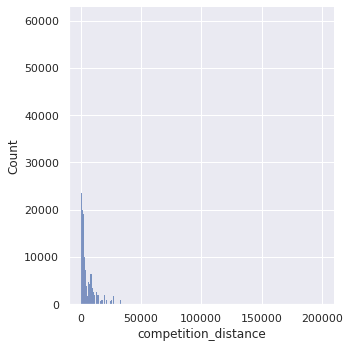

In [24]:
sns.displot(df1['competition_distance'])

### 1.7.2 Categorical Atributes

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

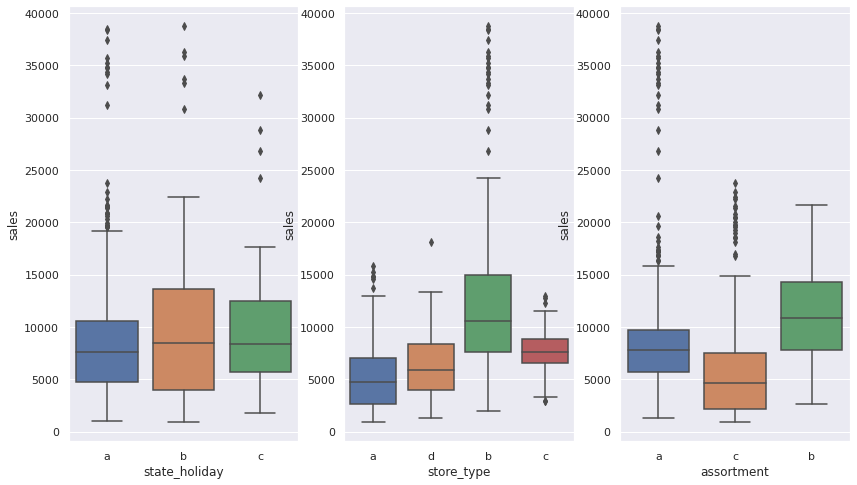

In [26]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.figure(figsize=(14, 8))
plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y='sales', data=aux1)

# 2.0 Feature Engineering

In [27]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

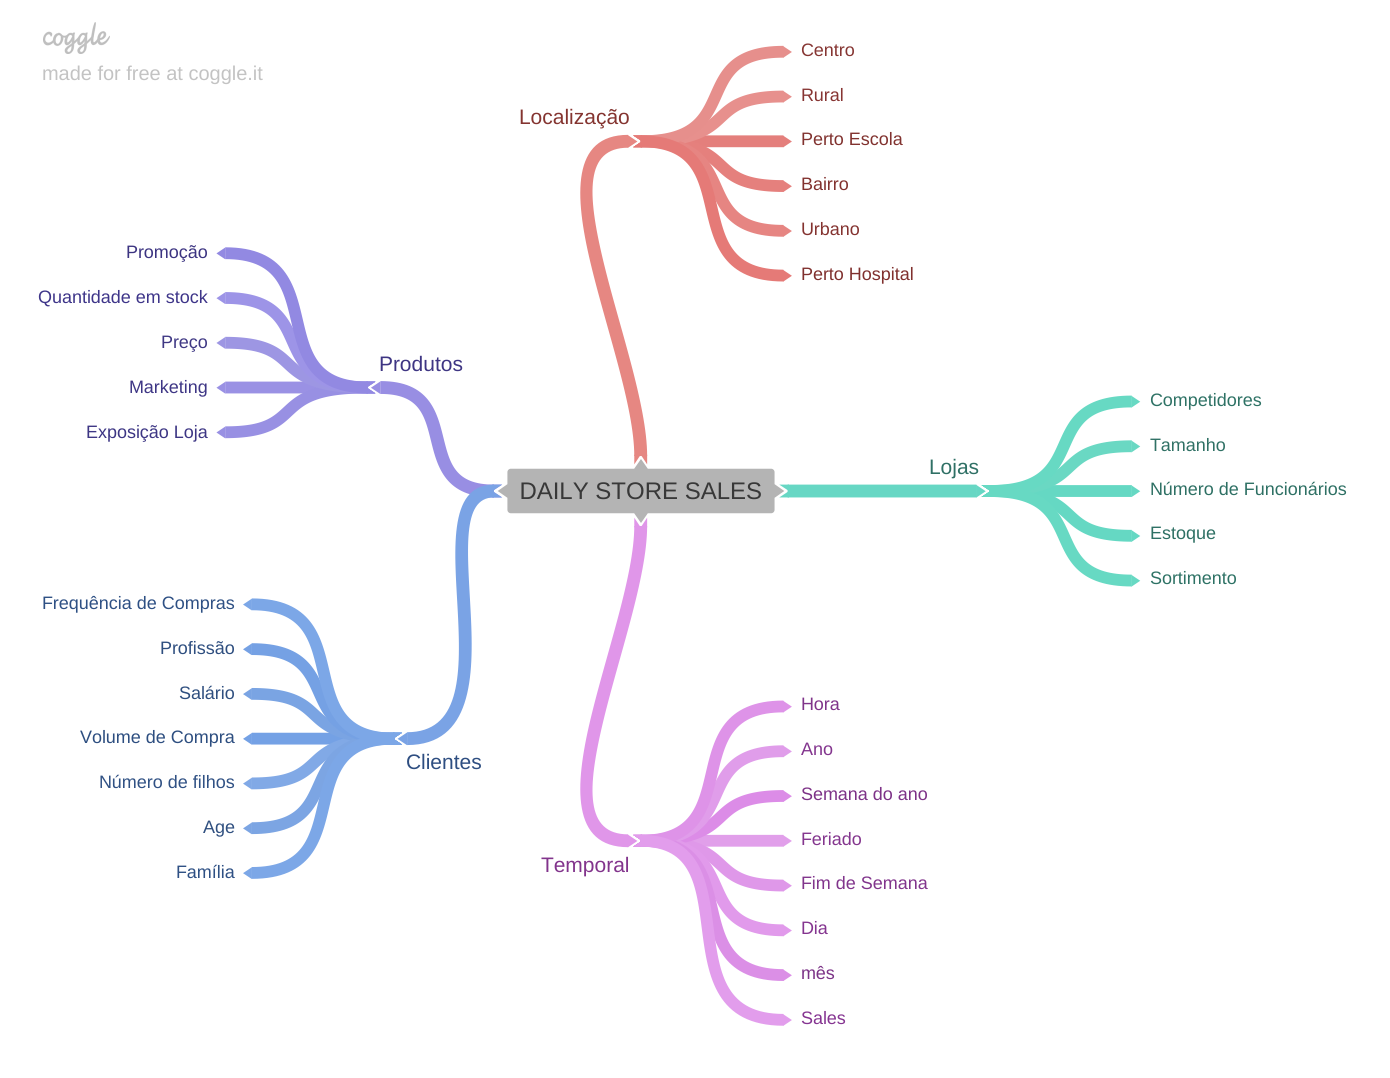

In [28]:
Image('img/mindmaphypothesis.png')

## 2.1 Criação das hipóteses

### 2.1.1 Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.**  Lojas com maior sortemento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista final de Hipóteses

**1.**  Lojas com maior sortemento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.



**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [29]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] ,month= x['competition_open_since_month'], day= 1 ), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days = 7) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

<ipython-input-29-1ba38fbc693f>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [30]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DE VARIÁVEIS

In [31]:
df3 = df2.copy()

In [32]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [33]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [34]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [35]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 ANÁLISE EXPLORATÓRIA DE DADOS

In [36]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

/home/caio/.pyenv/versions/3.8.0/envs/RossmanStoreSales/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

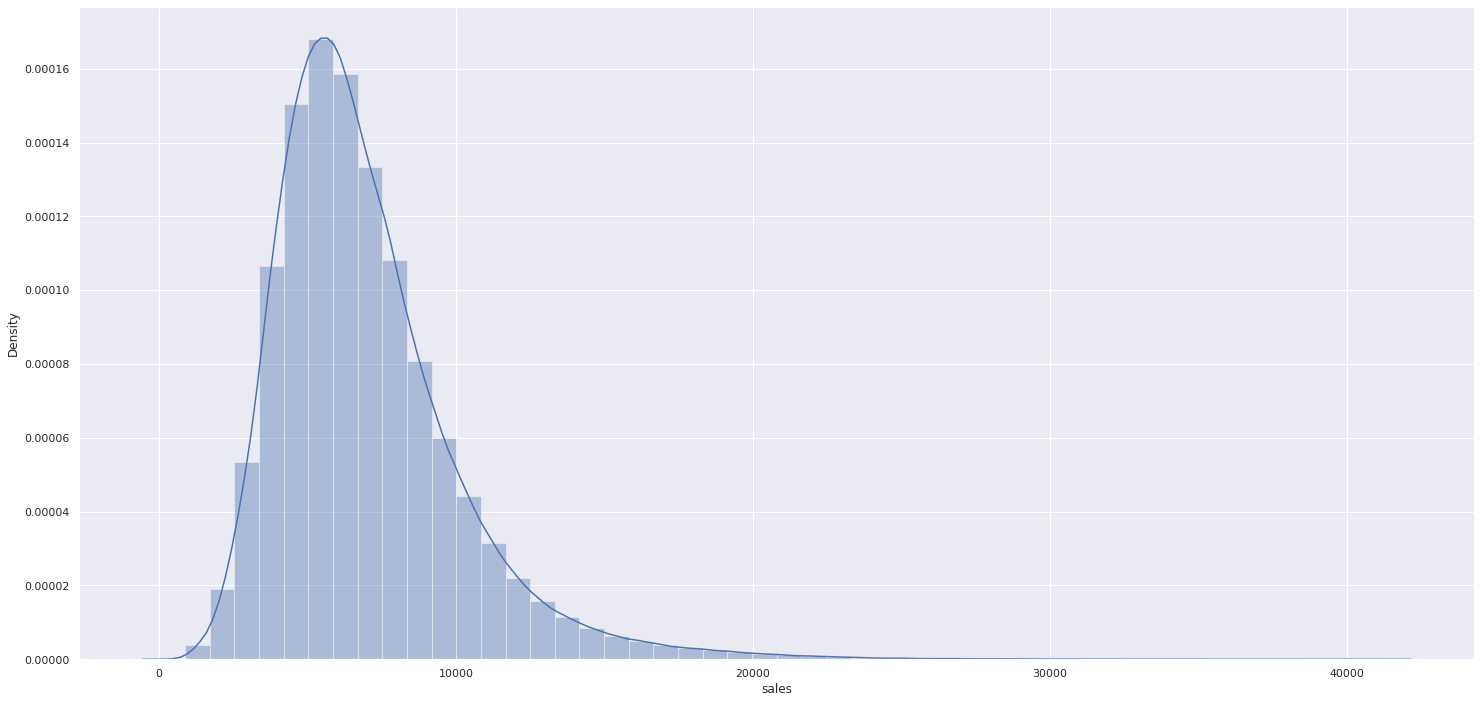

In [37]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical Variable

/home/caio/.pyenv/versions/3.8.0/envs/RossmanStoreSales/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


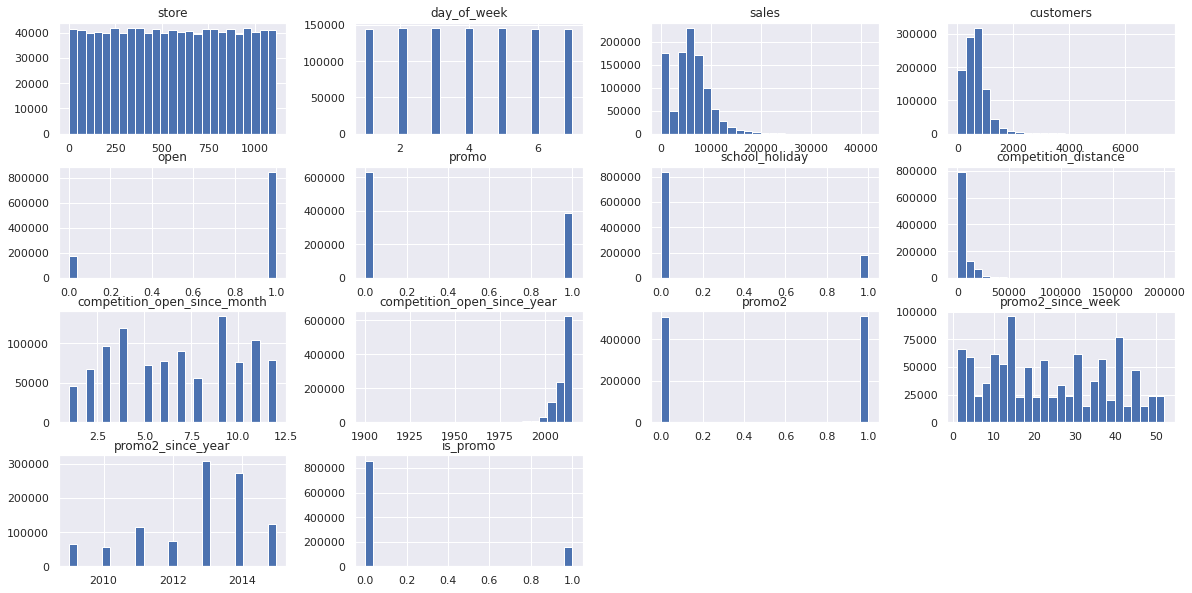

In [38]:
num_attributes.hist(figsize=(20,10),bins = 25);

### 4.1.3 Categorical Variable

In [39]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/home/caio/.pyenv/versions/3.8.0/envs/RossmanStoreSales/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/caio/.pyenv/versions/3.8.0/envs/RossmanStoreSales/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/caio/.pyenv/versions/3.8.0/envs/RossmanStoreSales/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments

<AxesSubplot:xlabel='sales', ylabel='Density'>

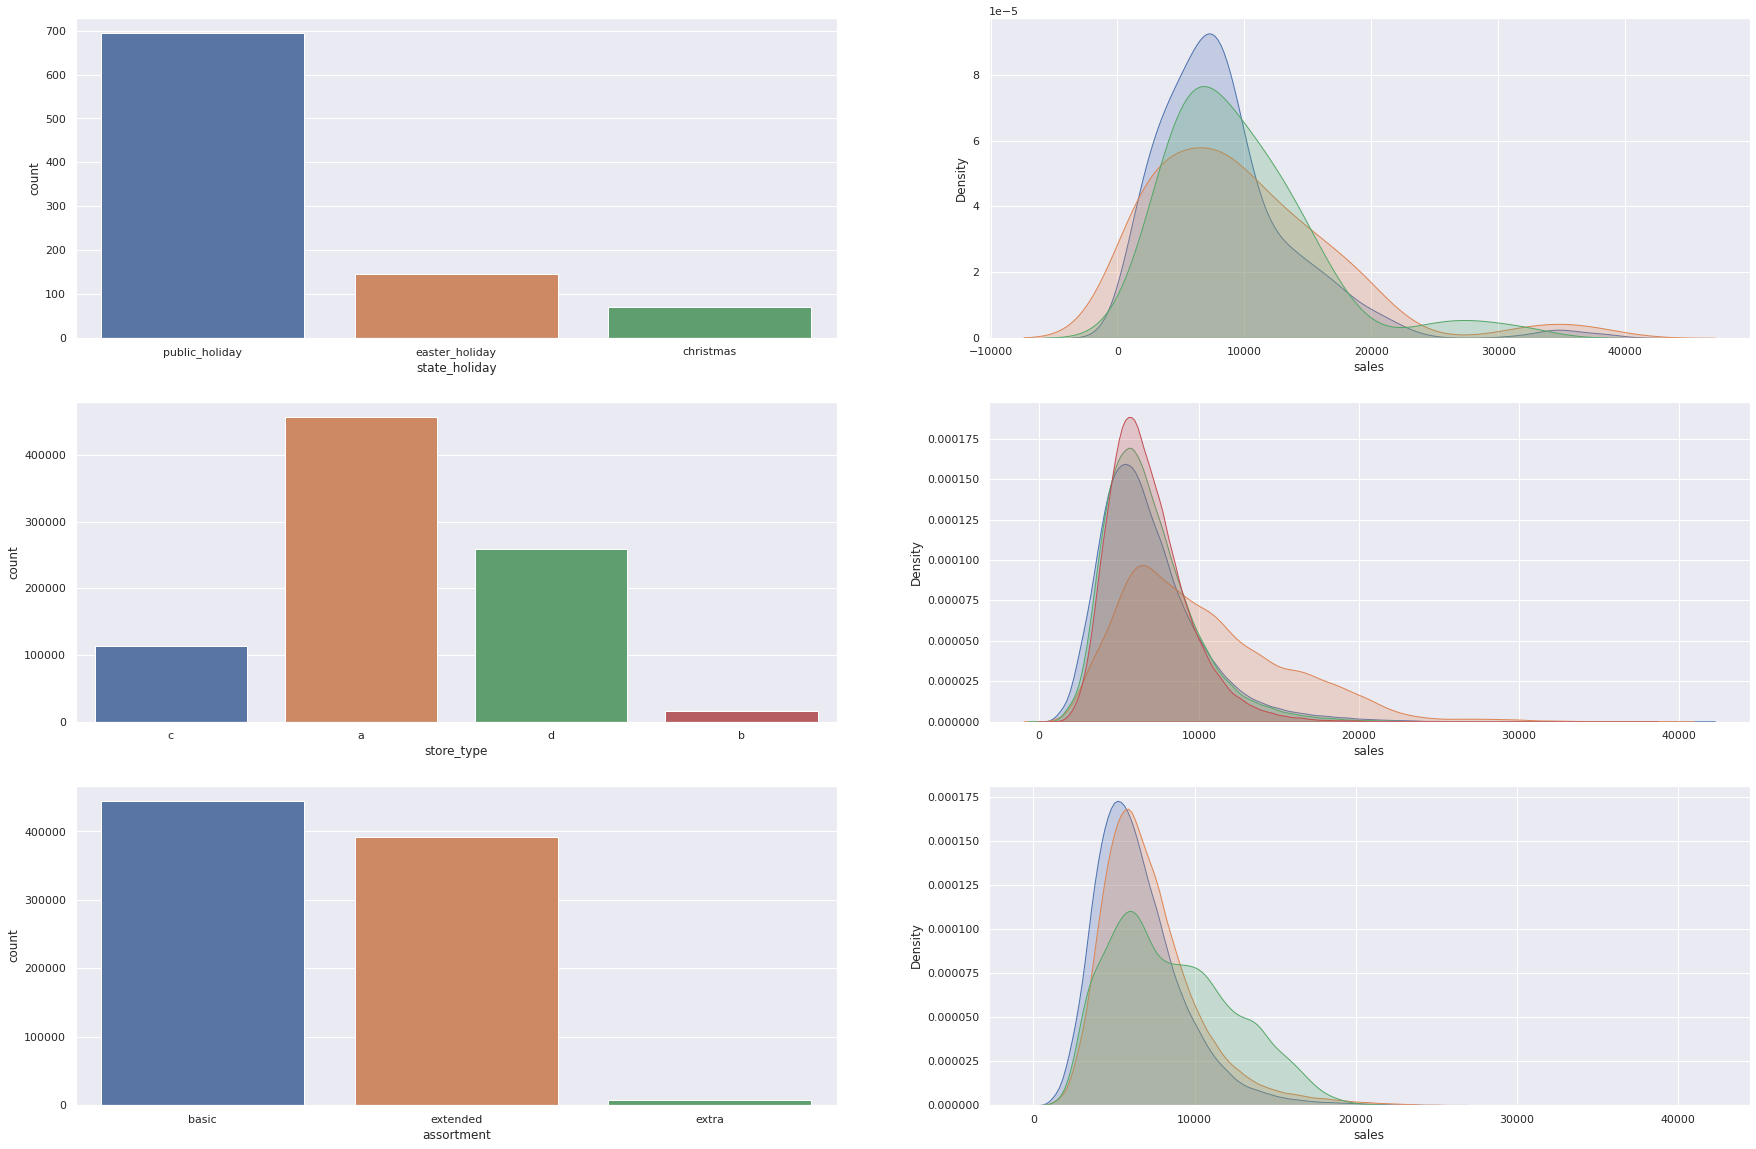

In [40]:
# state_holiday
plt.figure(figsize=(30,20))
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2 Análise Bivariada

### **H1.**  Lojas com maior sortemento deveriam vender mais.
***Falsa***. Lojas com maior sortimento vendem menos

<AxesSubplot:xlabel='year_week'>

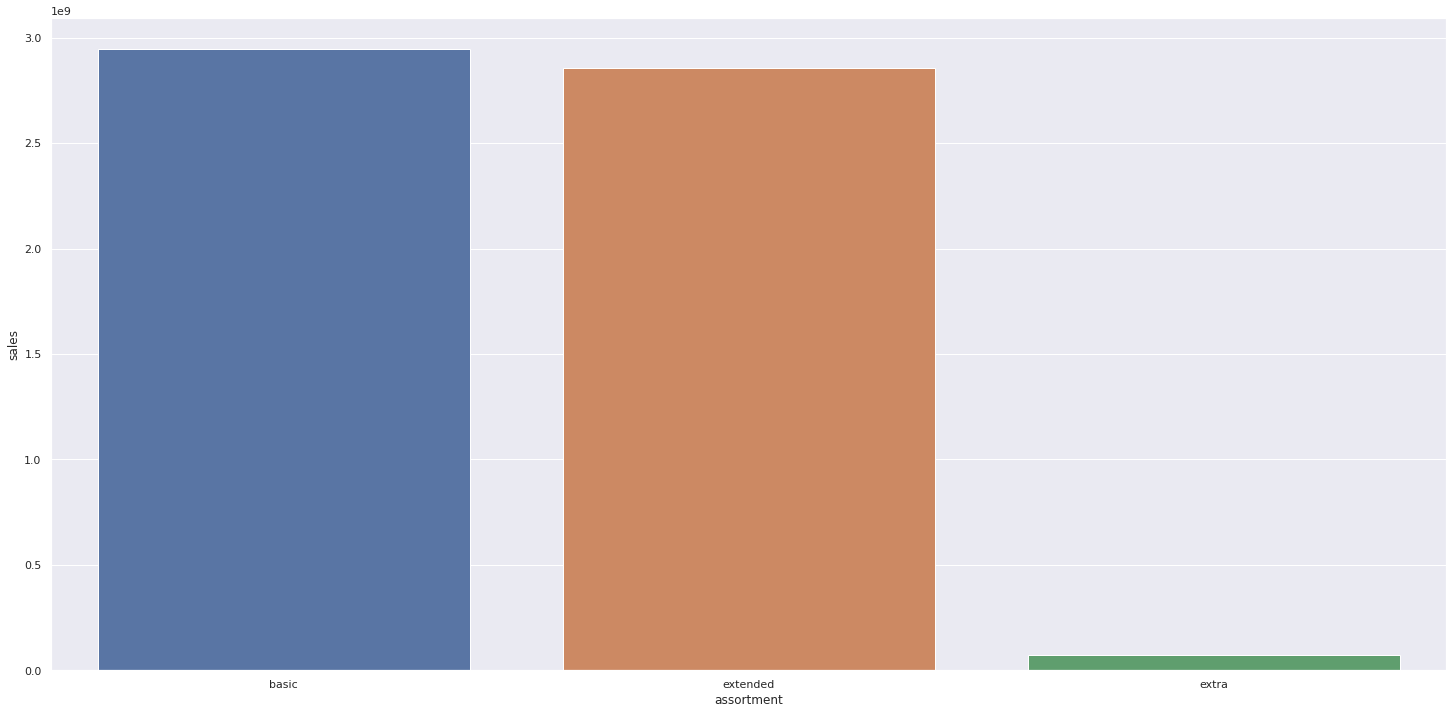

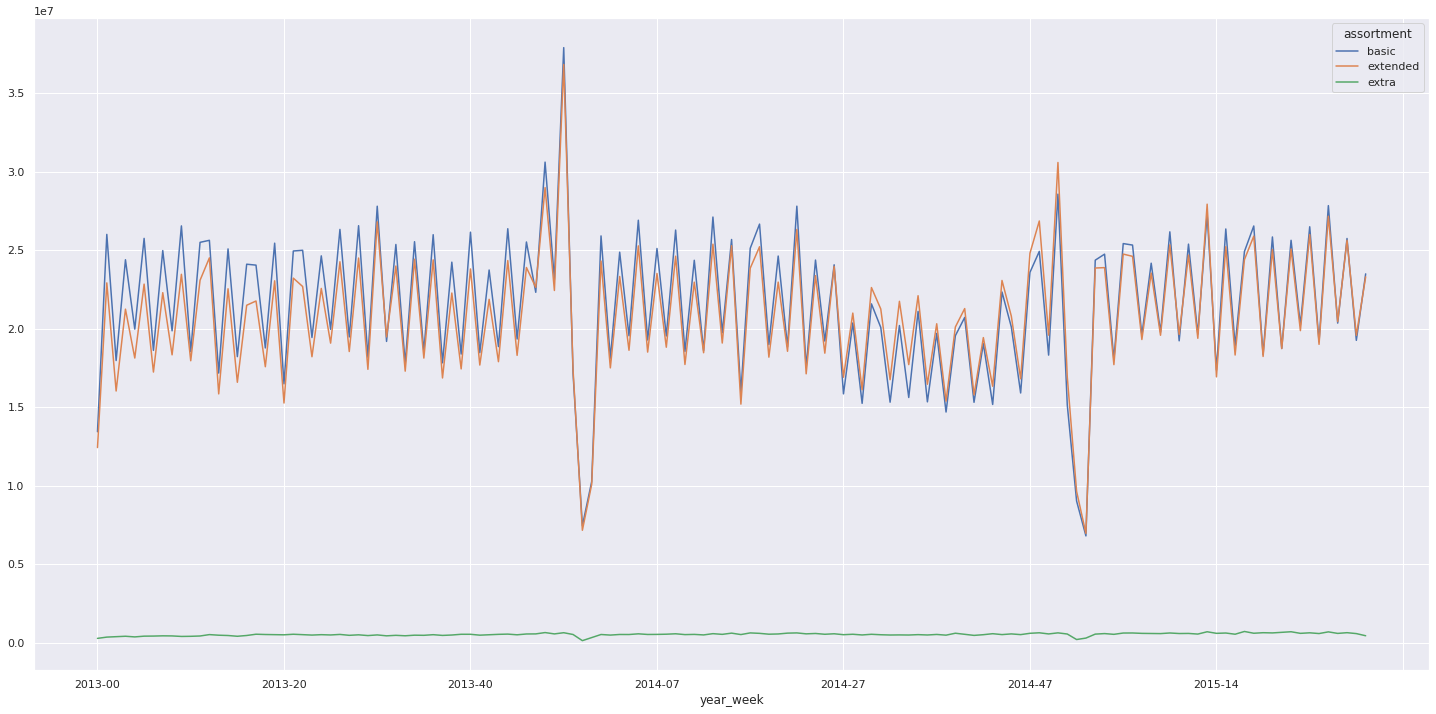

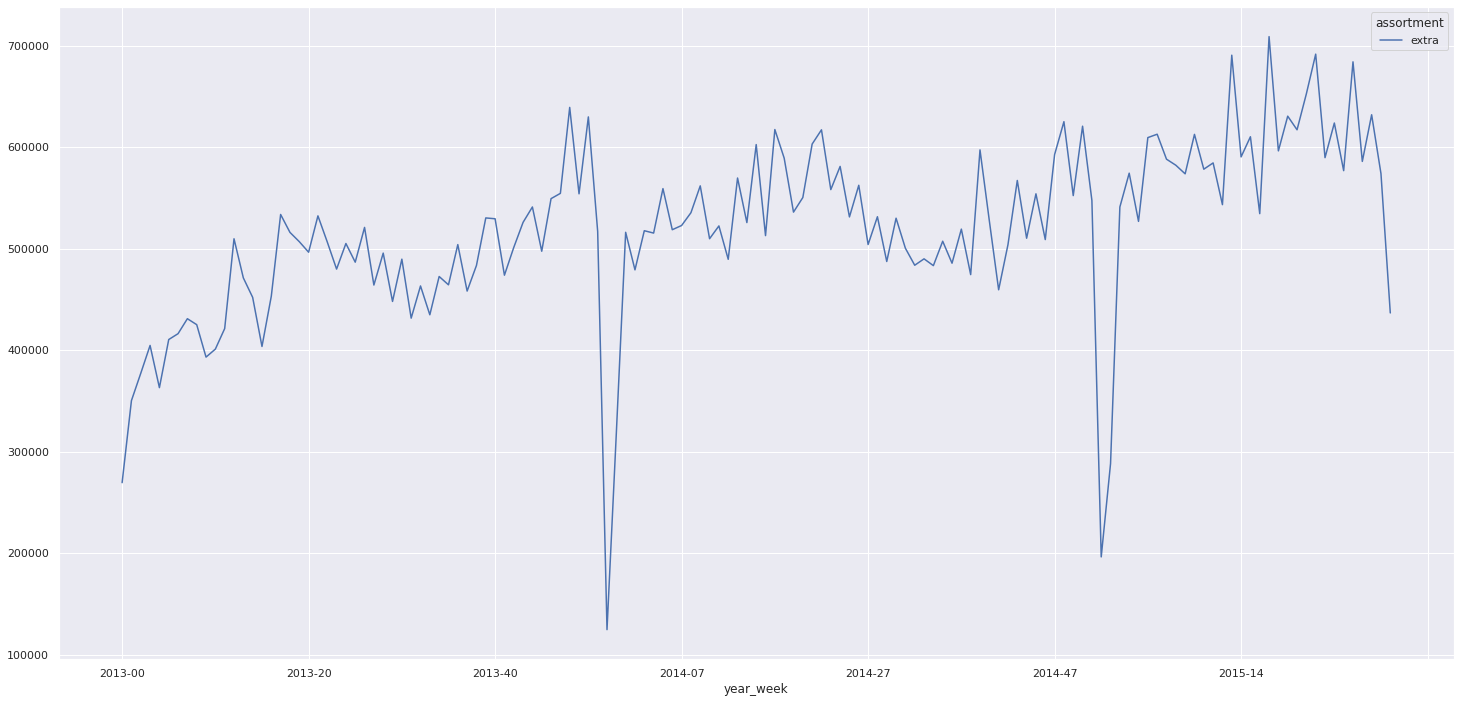

In [41]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux3 = aux2.pivot(index='year_week', columns = 'assortment', values = 'sales')
aux3.plot()

aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot(index='year_week', columns = 'assortment', values = 'sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
***Falsa***. Lojas com competidores mais próximos vendem mais.

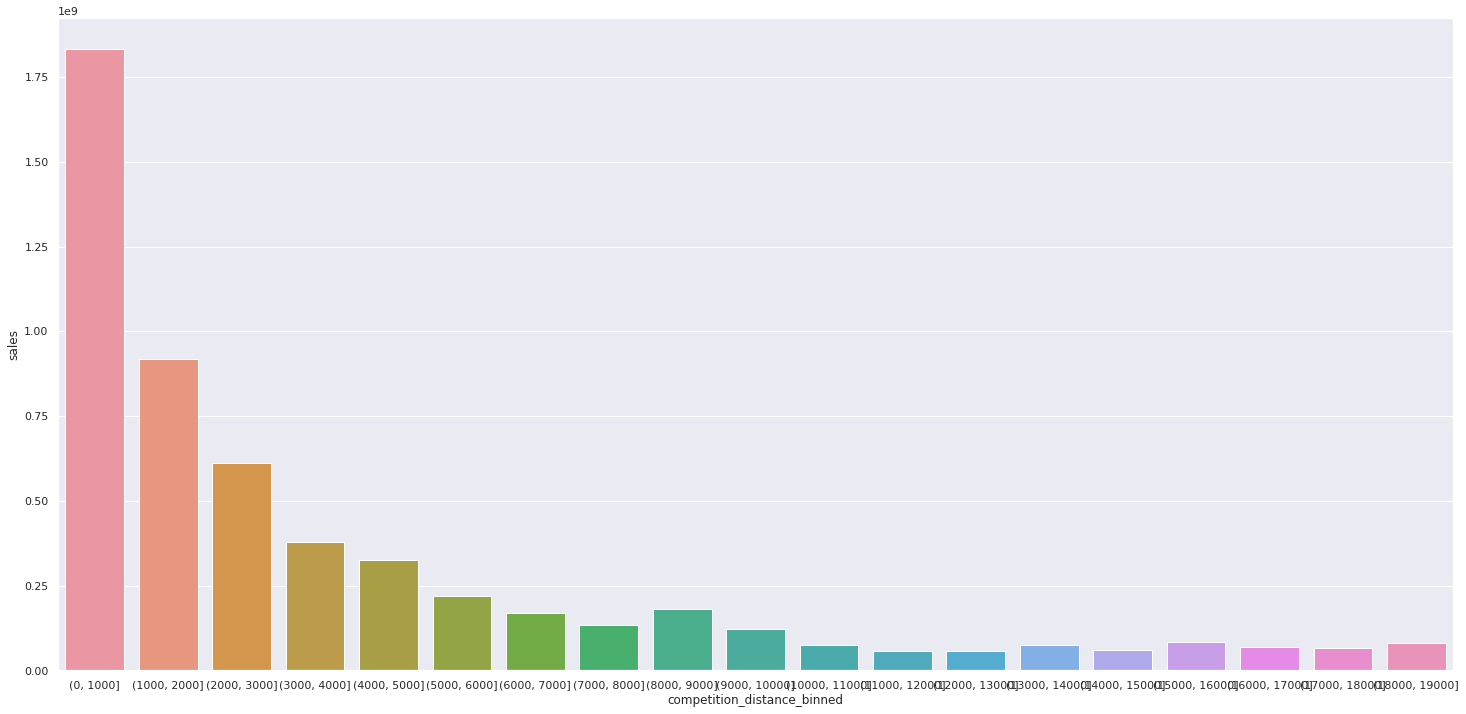

In [42]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y = 'sales', data = aux2);

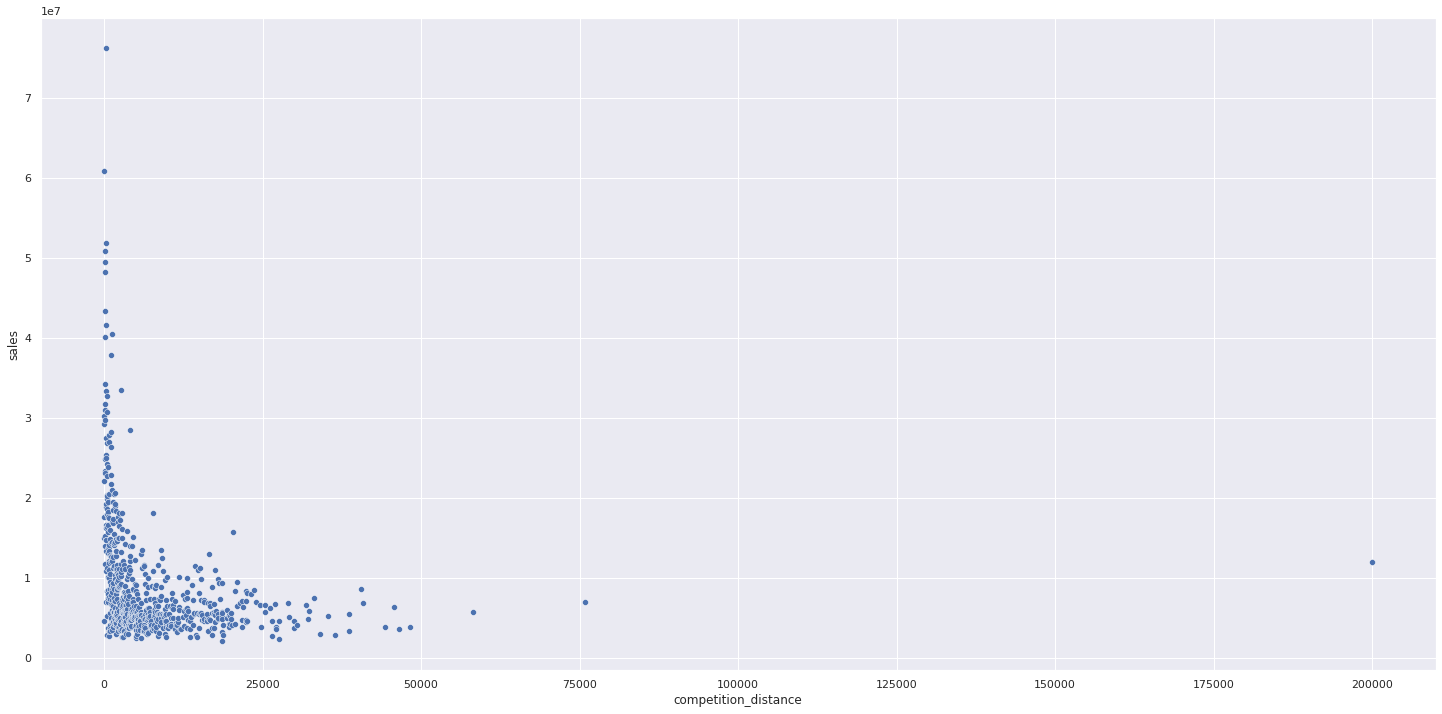

In [43]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

sns.scatterplot(x = 'competition_distance', y='sales', data = aux1);

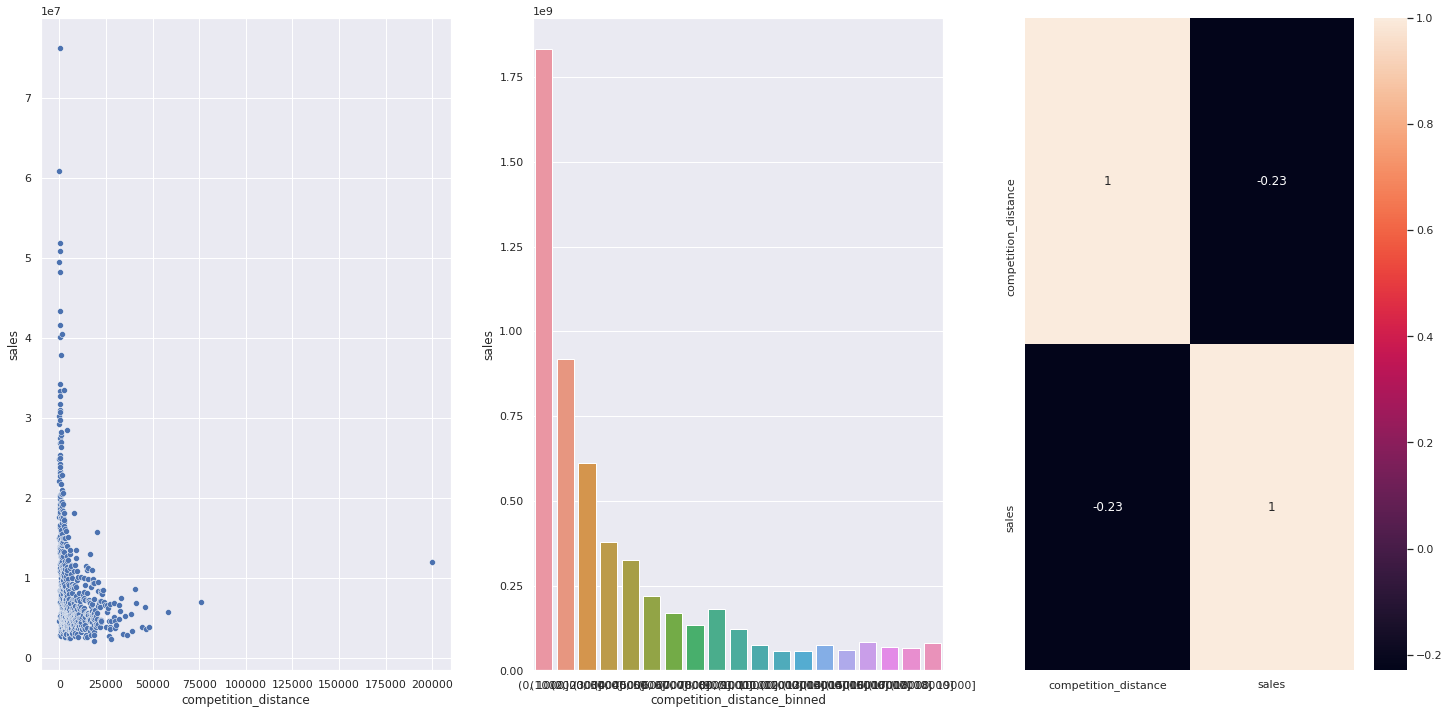

In [44]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data = aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y = 'sales', data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores a mais tempo deveriam vender mais.
***Falsa***. Lojas com competidores à mais tempo vendem menos.

<AxesSubplot:>

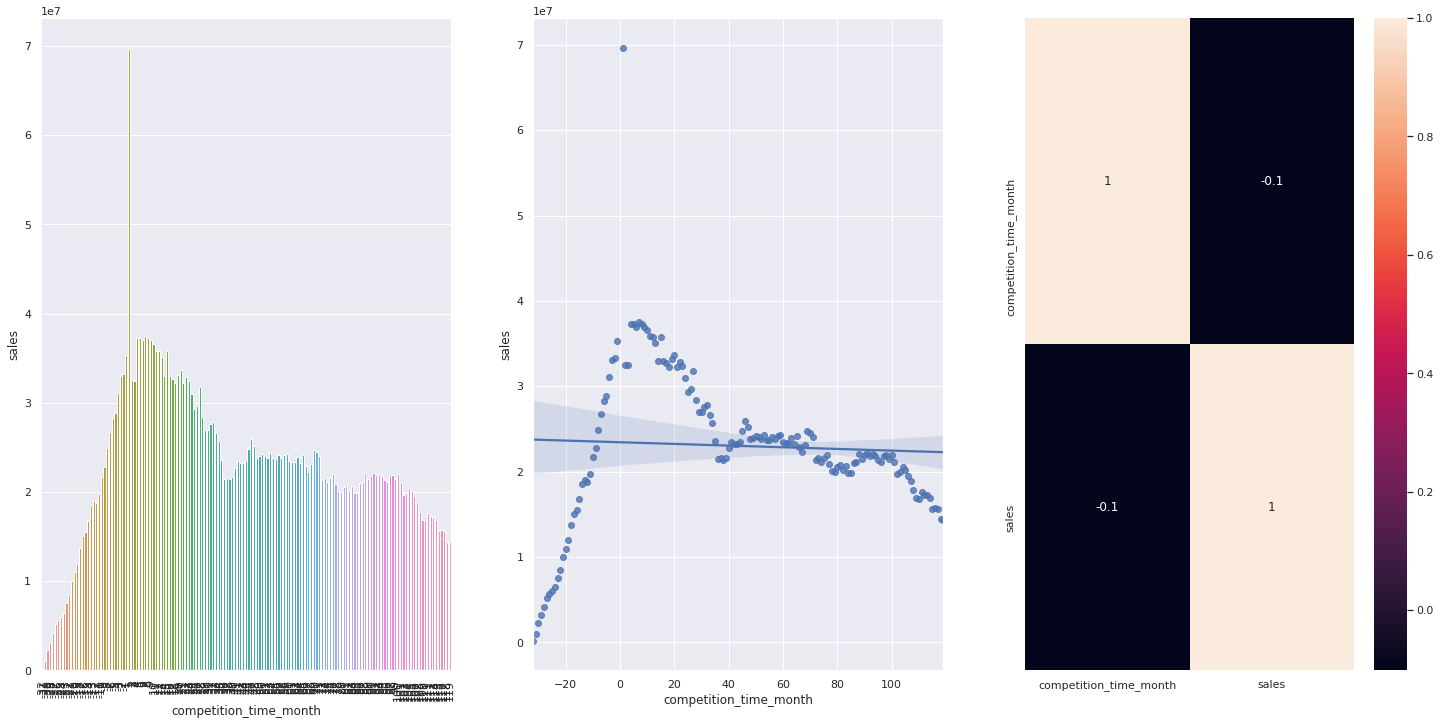

In [45]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data = aux2);
plt.xticks(rotation=90);


plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
***Falsa*** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

In [46]:
import matplotlib.gridspec as GridSpec

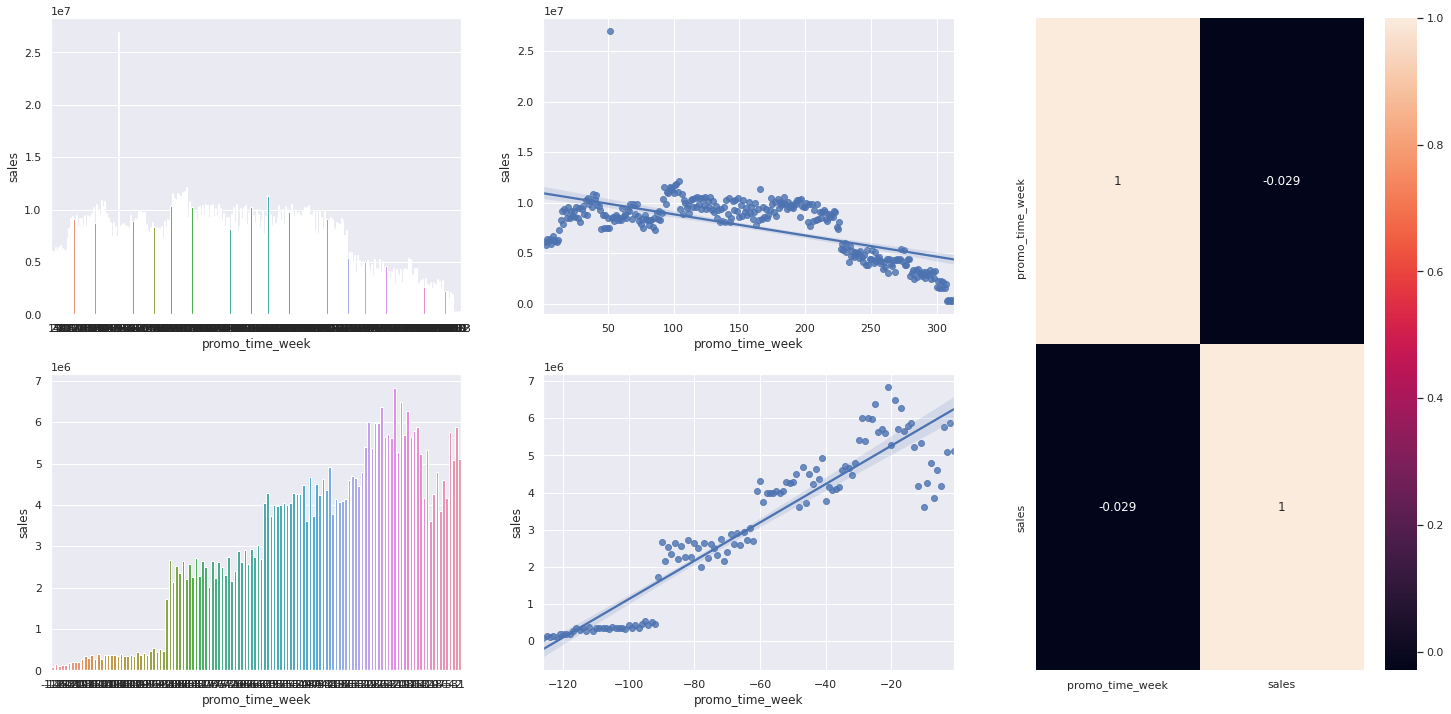

In [47]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec.GridSpec( 2,3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week']>0] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data = aux2);

plt.subplot( grid[0,1] )
sns.regplot(x='promo_time_week', y='sales', data = aux2);

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week']<0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data = aux3);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data = aux3);

plt.subplot( grid[:,2] )
sns.heatmap(aux1.corr(method='pearson'), annot = True);

### H5. Lojas com mais dias de promoção deveriam vender mais.

#### Faremos no próximo ciclo.

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
***Falsa*** Lojas com mais promoções consecutivas vendem menos.

In [48]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


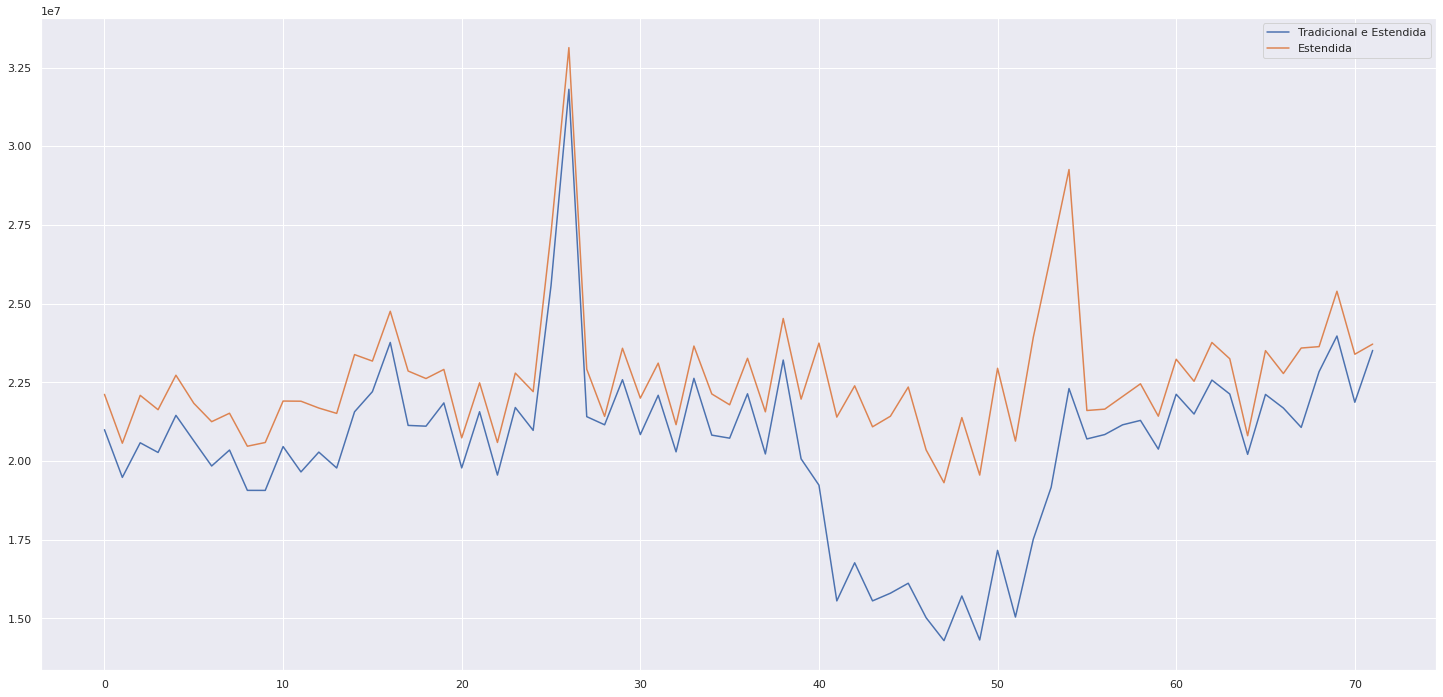

In [49]:
aux1 = df4[(df4['promo'] == 1) & ( df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & ( df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels=['Tradicional e Estendida', 'Estendida'])

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa** Lojas abertas durante o feriado de Natal vendem menos.

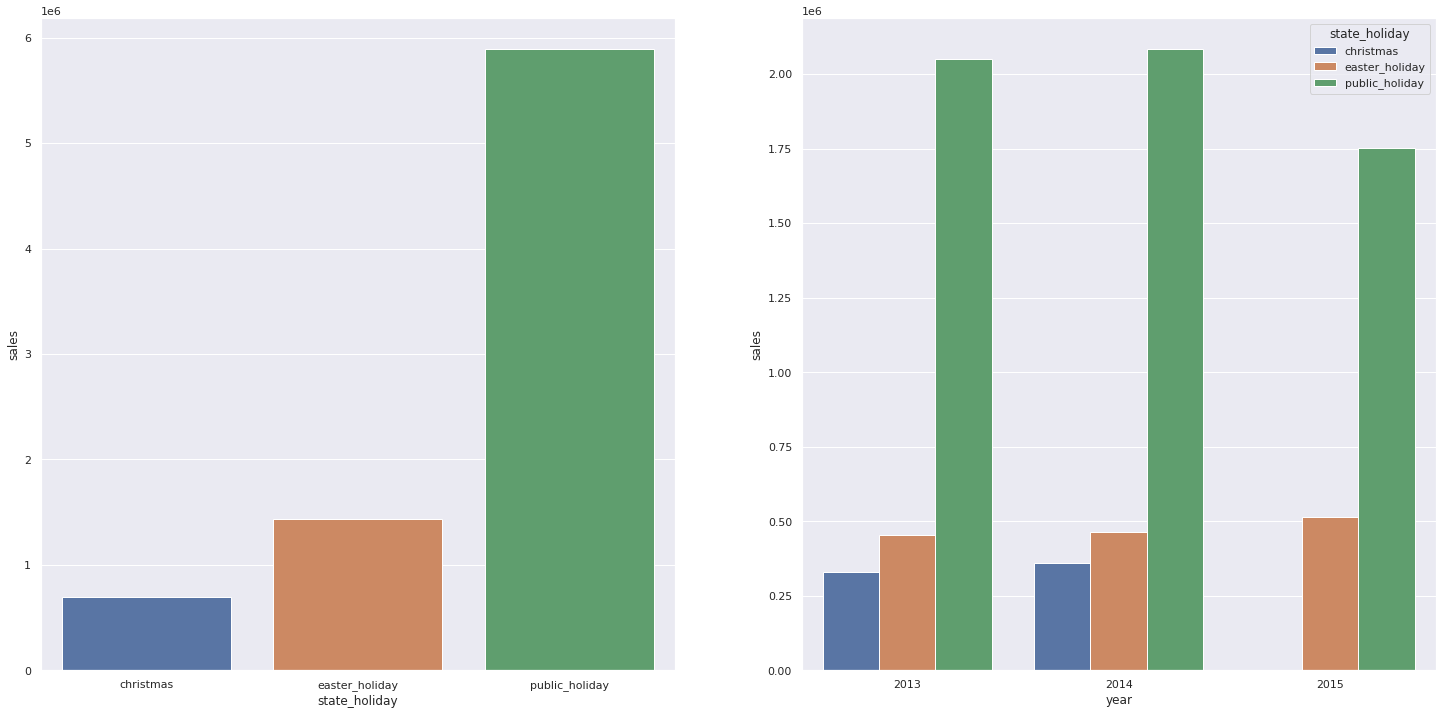

In [50]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y = 'sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y = 'sales', hue = 'state_holiday', data=aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.
***Falsa*** Lojas vendem menos ao longo dos anos.

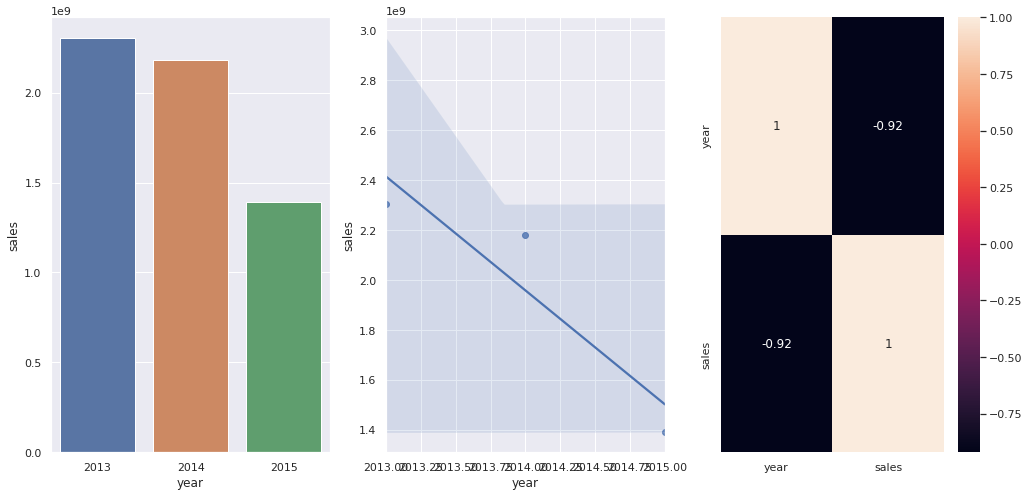

In [51]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(17, 8))

plt.subplot(1,3,1)
sns.barplot(x='year', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
***Falsa*** Lojas vendem menos no segundo semestre do ano.

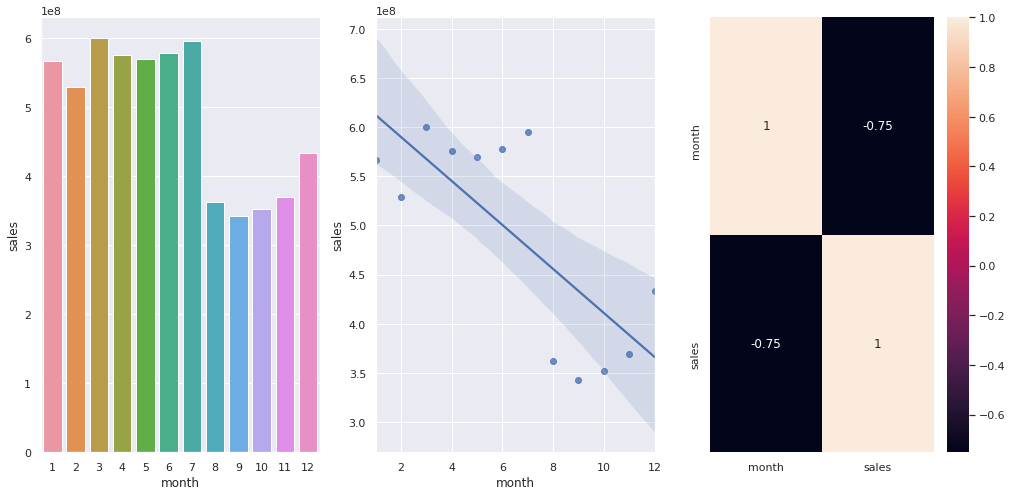

In [52]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(17, 8))

plt.subplot(1,3,1)
sns.barplot(x='month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
***Verdadeira*** Lojas vendem mais depois do dia 10 de cada mês.

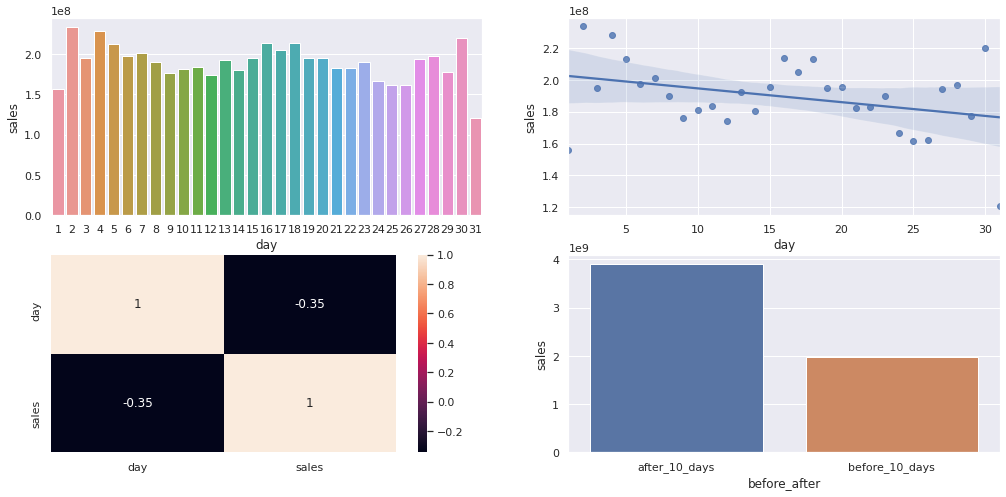

In [53]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(17, 8))

plt.subplot(2,2,1)
sns.barplot(x='day', y = 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y = 'sales', data=aux2);

In [54]:
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux1.tail()

,day,sales,before_after
26,27,194264879,after_10_days
27,28,196952797,after_10_days
28,29,177114239,after_10_days
29,30,219939617,after_10_days
30,31,120659889,after_10_days


### H11. Lojas deveriam vender menos aos finais de semana.
***Verdadeira*** Lojas vendem menos nos finais de semana.

In [55]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


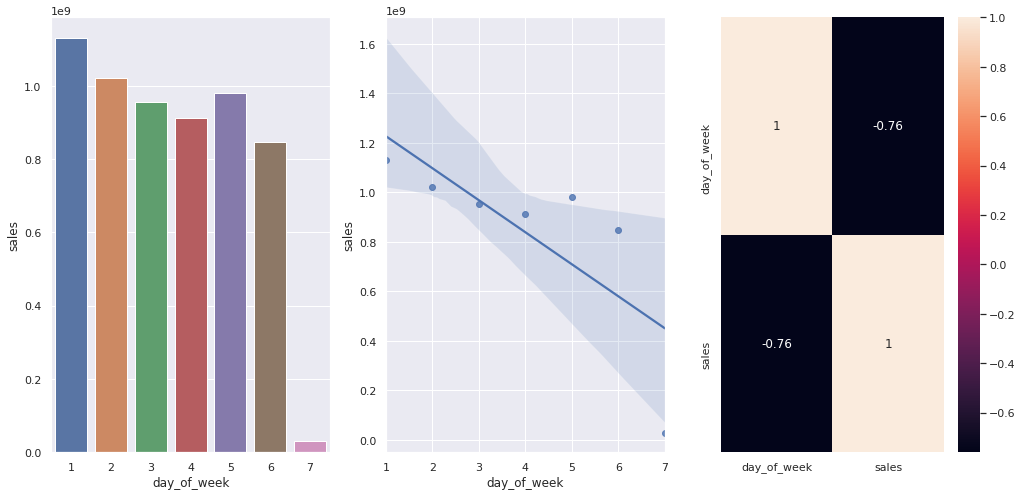

In [56]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(17, 8))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
***Verdadeira*** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

In [57]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


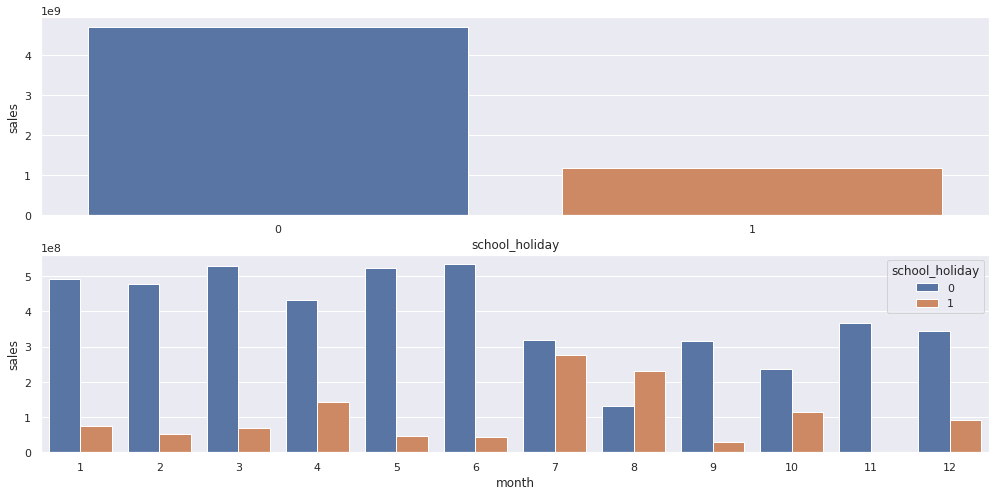

In [58]:
plt.figure(figsize=(17, 8))
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y = 'sales', data = aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y = 'sales', hue='school_holiday', data = aux2);

## 4.3 Análise Multivariada

### 4.3.1. Numerical Attributes

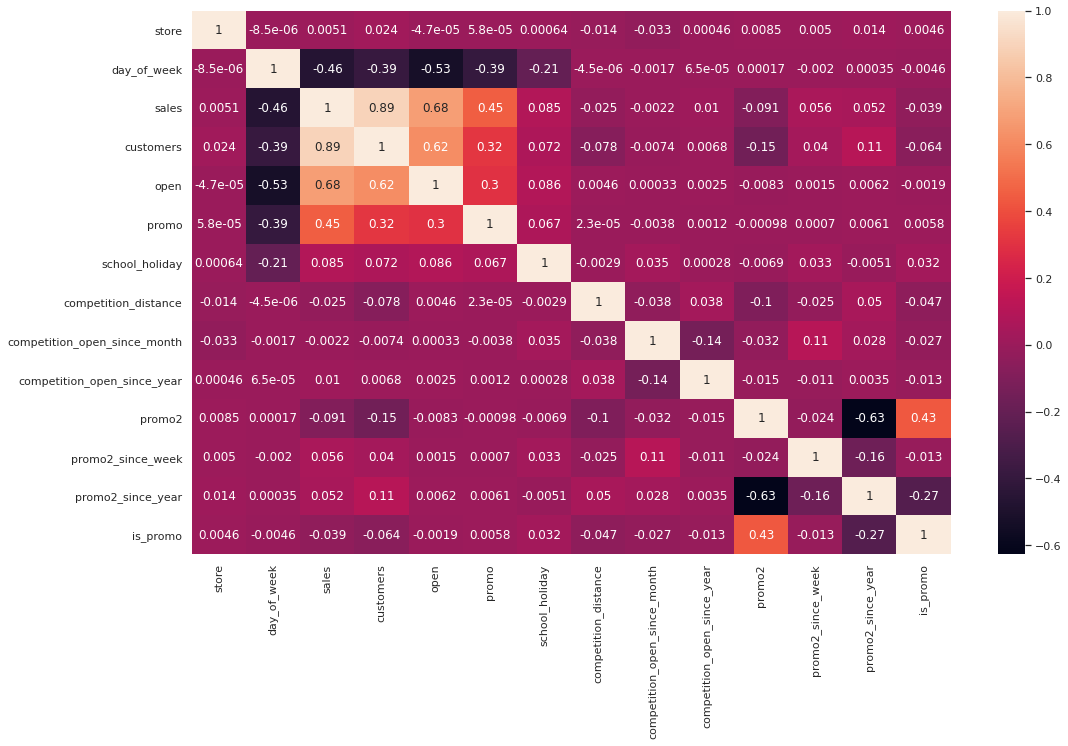

In [59]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(17, 10))
sns.heatmap(correlation, annot = True);

### 4.3.2. Categorical Attributes

In [60]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

In [61]:
a = df4.select_dtypes(include = 'object')

In [62]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [63]:
cm = pd.crosstab(a['state_holiday'], a['store_type']).values

In [64]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()

    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm ) [0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min( (kcorr-1) , (rcorr-1) ) ) )

In [65]:
a = df4.select_dtypes(include = 'object')

<AxesSubplot:>

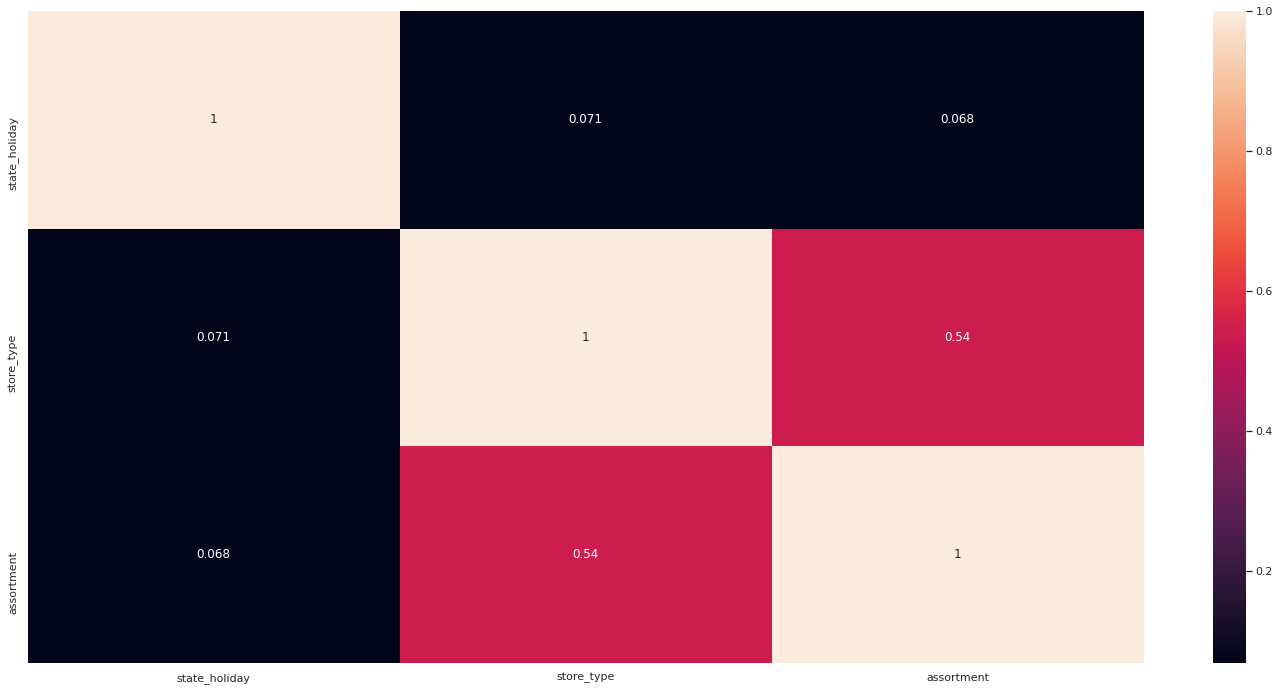

In [66]:
#Only Categorical Data
a = df4.select_dtypes(include = 'object')

#Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final dataset
d= pd.DataFrame( {'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]
              } )
d = d.set_index(d.columns)
sns.heatmap(d,annot = True)

# 5.0 DATA PREPARATION

In [67]:
df5 = df4.copy()

## 5.1 Normalização

Observando a seção 4.1.2 podemos observar que não temos nenhuma variável com uma distribuição normal (gaussiana), logo, este tipo de transformação não é útil para o nosso caso.

## 5.2 Rescaling

In [68]:
a = df5.select_dtypes(include=['int64', 'float64','int32'])

In [69]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [70]:
# competition_distance
# year
# competition_time_month
# promo_time_week

/home/caio/.pyenv/versions/3.8.0/envs/RossmanStoreSales/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='promo_time_week'>

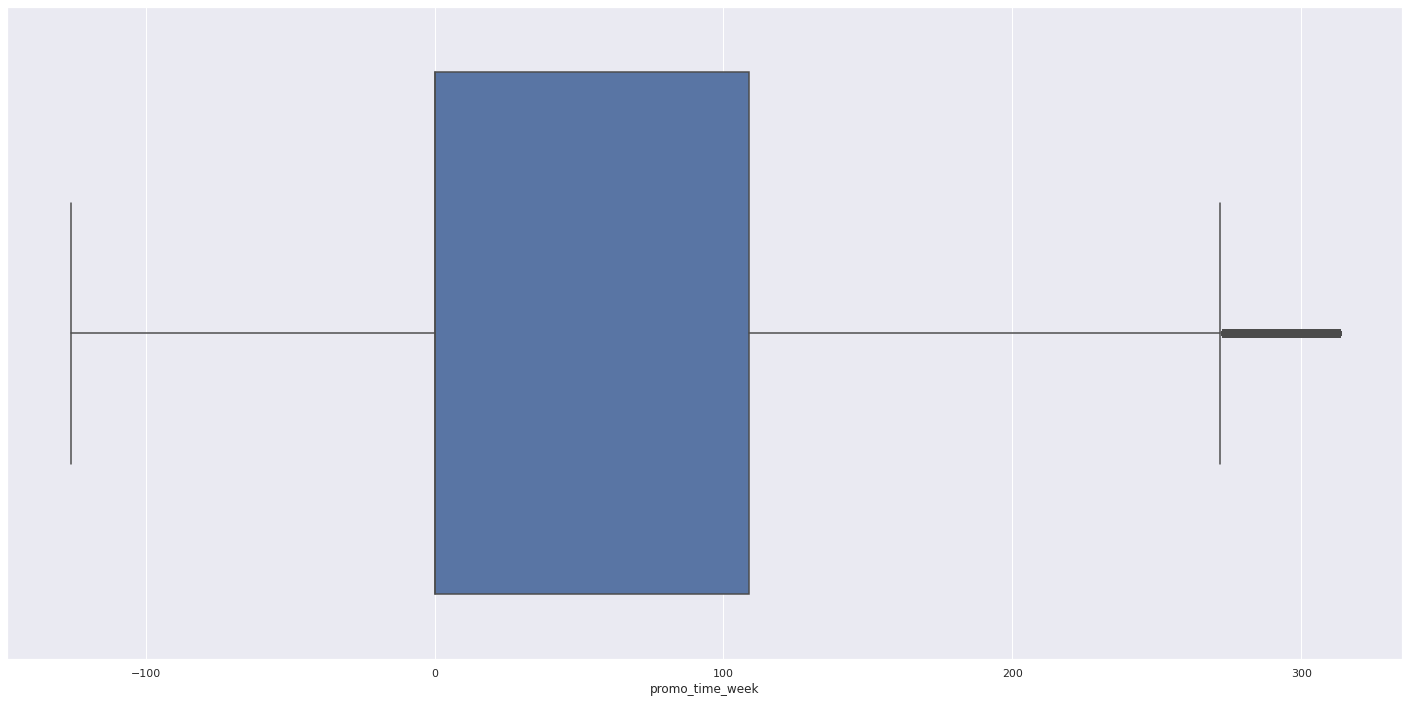

In [71]:
sns.boxplot(df5['promo_time_week'])

In [72]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [73]:
rs = RobustScaler()
mms = MinMaxScaler()
#Competition_Distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values )

#Competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )

#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

/home/caio/.pyenv/versions/3.8.0/envs/RossmanStoreSales/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

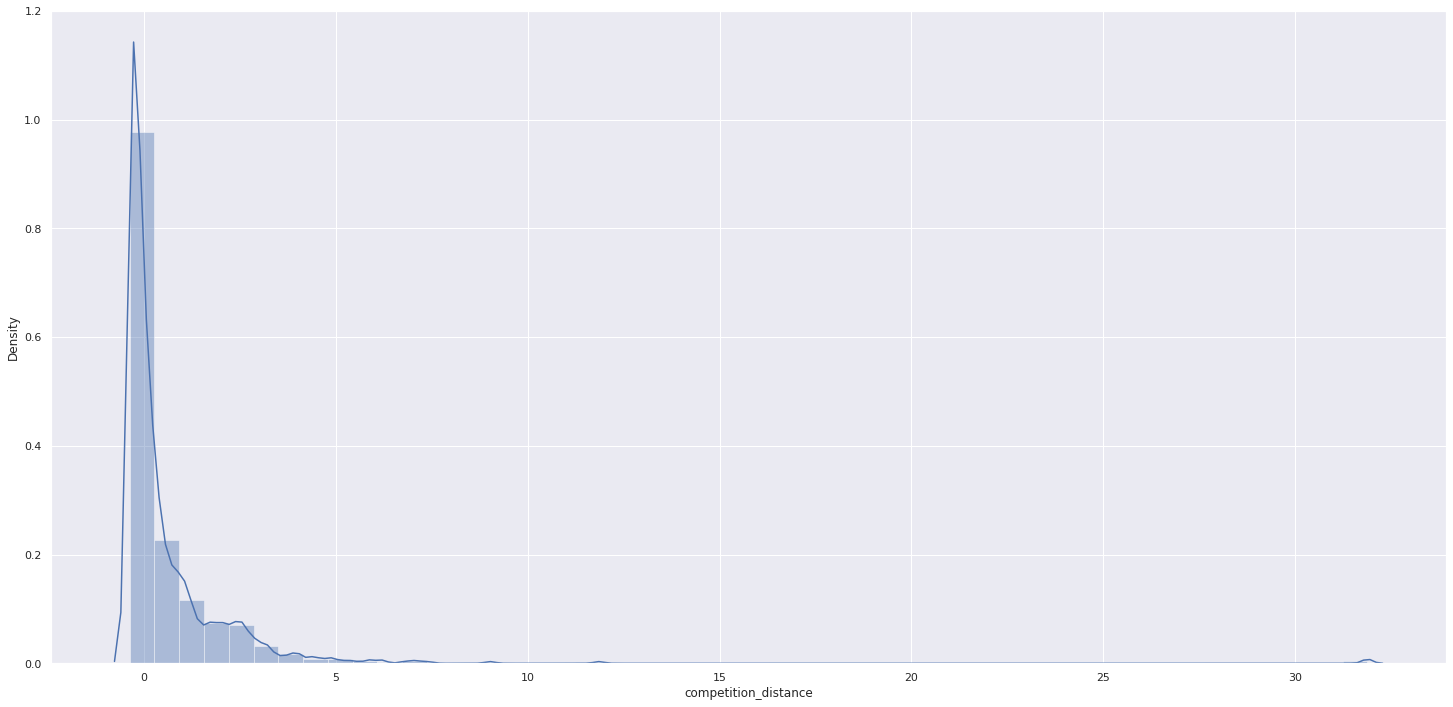

In [74]:
sns.distplot(df5['competition_distance'])

## 5.3 Transformação

### 5.3.1 Encoding

In [75]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [76]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns = ['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment  - Ordinal Encoding
assortment_dict = {'basic': 1,
                  'extra': 2,
                  'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [77]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2 Response Variable Transformation

In [78]:
df5['sales'] = np.log1p(df5['sales'])

/home/caio/.pyenv/versions/3.8.0/envs/RossmanStoreSales/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

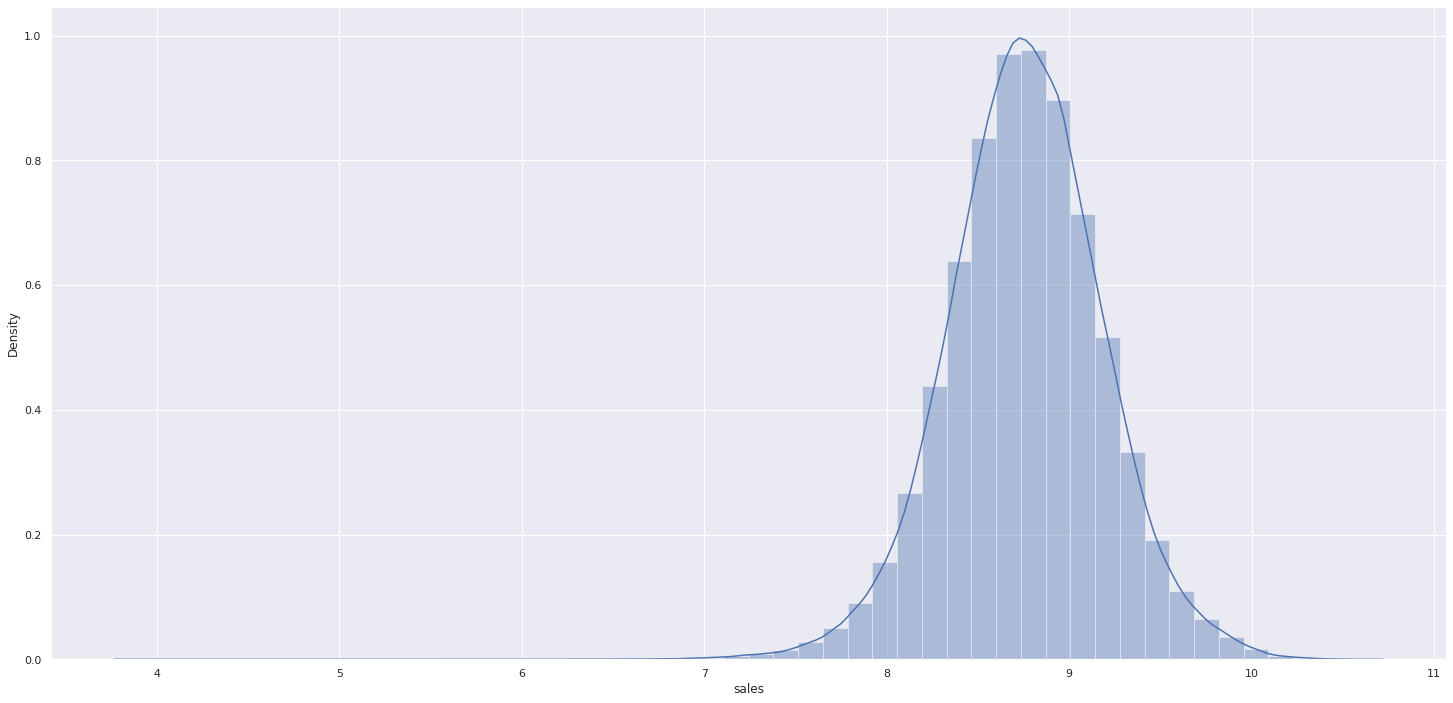

In [79]:
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [80]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

In [81]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0 FEATURE SELECTION

In [82]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [83]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [84]:
cols_drop = ['week_of_year','day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1 )

In [85]:
df6[['store', 'date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
5,6,2013-01-02
6,7,2013-01-02
7,8,2013-01-02
8,9,2013-01-02
9,10,2013-01-02


In [86]:
df6[['store', 'date']].groupby('store').max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
5,6,2015-07-31
6,7,2015-07-31
7,8,2015-07-31
8,9,2015-07-31
9,10,2015-07-31


In [87]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0]

Timestamp('2015-07-31 00:00:00')

In [88]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [89]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Teste Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Teste Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [90]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [91]:
#training and test for boruta
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor (n_jobs = -1)

#boruta = BorutaPy(rf, n_estimators='auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n)    # Demora 2h 30min para rodar.

### 6.2.1 Best Features from Boruta

In [92]:
#cols_selected = boruta.support_.tolist()

X_train_fs = X_train.drop(['date','sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list() 
cols_selected_boruta = ['store',  'promo', 'store_type', 'assortment',  'competition_distance', 'competition_open_since_month',  'competition_open_since_year',
 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos',
 'day_of_week_sin', 'day_of_week_cos']

#not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )
cols_not_selected_boruta = ['is_promo', 'month_sin', 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter_holiday', 'state_holiday_public_holiday',
                           'state_holiday_regular_day', 'week_of_year_sin', 'year']

In [93]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [94]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3 Manual Feature Selection

In [95]:
cols_selected_boruta = ['store',  'promo', 'store_type', 'assortment',  'competition_distance', 'competition_open_since_month',  'competition_open_since_year',
 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_cos',
 'day_of_week_sin', 'day_of_week_cos']

feat_to_add = ['date', 'sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [96]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']

# 7. Machine Learning Modeling

In [97]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]
 
#Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

In [98]:
x_train.dtypes

store                             int64
promo                             int64
store_type                        int64
assortment                        int64
competition_distance            float64
competition_open_since_month      int64
competition_open_since_year       int64
promo2                            int64
promo2_since_week                 int64
promo2_since_year                 int64
competition_time_month          float64
promo_time_week                 float64
month_cos                       float64
day_sin                         float64
day_cos                         float64
week_of_year_cos                float64
day_of_week_sin                 float64
day_of_week_cos                 float64
dtype: object

## 7.1 Average Model

In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [100]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs( (y - yhat)/y ))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])

In [101]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')

yhat_baseline = aux1['predictions']

#preformance
baseline_result = ml_error('Average_Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result 

,Model Name,MAE,MAPE,RMSE
0,Average_Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [102]:
from sklearn.linear_model import LinearRegression, Lasso

In [103]:
#Model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1869.922218,0.295044,2667.521087


### 7.2.1 Linear Regression Model - CrossValidation

In [104]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Linear Regression,2079.28 +/- 303.04,0.3 +/- 0.02,2961.07 +/- 473.32


## 7.3 Linear Regression Regularized Model

In [105]:
#Model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.194994,0.289872,2741.003247


### 7.3.1 Lasso - CrossValidation

In [106]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Lasso,2116.98 +/- 342.05,0.29 +/- 0.01,3059.41 +/- 504.65


## 7.4 Random Forest Regressor

In [107]:
from sklearn.ensemble import RandomForestRegressor

In [108]:
#Model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,730.15919,0.108591,1073.35176


### 7.4.1 Random Forest Regressor - CrossValidation

In [109]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True)
rf_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor,841.89 +/- 223.36,0.12 +/- 0.02,1260.65 +/- 328.47


## 7.5 XGBoost Regressor

In [110]:
import xgboost as xgb

In [111]:
#Model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                            n_estimators = 100,
                            eta = 0.01,
                            max_depth = 10,
                            subsample = 0.7,
                            colsample_bytree = 0.9).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6682.267373,0.949287,7329.447733


### 7.5.1 XGBoost Regressor - CrossValidation

In [113]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
xgb_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,XGBoost Regressor,7049.44 +/- 588.56,0.95 +/- 0.0,7715.51 +/- 689.36


# 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [117]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,730.159190,0.108591,1073.351760
0,Average_Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1869.922218,0.295044,2667.521087
0,Linear Regression - Lasso,1891.194994,0.289872,2741.003247
0,XGBoost Regressor,6682.267373,0.949287,7329.447733


### 7.6.2 Real Performance - CrossValidation

In [118]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE_CV')

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor,841.89 +/- 223.36,0.12 +/- 0.02,1260.65 +/- 328.47
0,Linear Regression,2079.28 +/- 303.04,0.3 +/- 0.02,2961.07 +/- 473.32
0,Lasso,2116.98 +/- 342.05,0.29 +/- 0.01,3059.41 +/- 504.65
0,XGBoost Regressor,7049.44 +/- 588.56,0.95 +/- 0.0,7715.51 +/- 689.36


In [ ]:
x_training = X_train[cols_selected_boruta_full]

In [ ]:
x_training.head()

In [ ]:
# start and end date for validation

validation_start_date = x_training['date'].max() - datetime.timedelta(days = 1*6*7)
validation_end_date = x_training['date'].max() - datetime.timedelta(days = 0*6*7)

# filtering dataset
training = x_training[x_training['date']  < validation_start_date ]
validation = x_training[(x_training['date']  >= validation_start_date  ) & (x_training['date']  <= validation_end_date  )]

In [ ]:
training['date'].min()

In [ ]:
training['date'].max()

In [ ]:
validation['date'].min()

In [ ]:
validation['date'].max()

In [ ]:
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []


    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKfold Number: {}'.format(k))
        # start and end date for validation

        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date']  < validation_start_date ]
        validation = x_training[(x_training['date']  >= validation_start_date  ) & (x_training['date']  <= validation_end_date  )]

        #training and validation dataset
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)
        
        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE_CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE_CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE_CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

In [ ]:
x_training = X_train[cols_selected_boruta_full]

In [ ]:
model = Lasso(alpha = 0.01)
a = cross_validation(x_training, 5, 'Lasso', model)

In [ ]:
a 